In [ ]:
# =============================================================================
# Esempio: Regressioni (Linear, Ridge, Lasso) su dati degli ultimi 2 anni
# =============================================================================
#
# In questo script:
# 1. Recuperiamo i dati storici di JP Morgan (JPM) da Alpha Vantage.
# 2. Filtriamo i dati per conservare solo gli ultimi 2 anni.
# 3. Ingegnerizziamo alcune feature (ritorno giornaliero, medie mobili, volatilità).
# 4. Creiamo un modello baseline di Regressione Lineare e poi confrontiamo
#    con Ridge e Lasso.
# 5. Confrontiamo MSE e R², e mostriamo i coefficienti.
#
# =============================================================================

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import datetime

# -----------------------------
# 1. Parametri e Funzioni
# -----------------------------
API_KEY = "003LNB7GX6QL9TY2"  # Inserisci la tua API Key
symbol = "AAPL"                # Titolo JP Morgan Chase

# URL per scaricare i dati daily con outputsize=full
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full"

# -----------------------------
# 2. Download e Preparazione Dati
# -----------------------------
print("Recupero dati da Alpha Vantage...")
response = requests.get(url)
if response.status_code != 200:
    raise Exception("Errore nella chiamata API. Controlla la connessione o la chiave API.")

data = response.json()
if "Time Series (Daily)" not in data:
    raise Exception("Struttura dati inaspettata. 'Time Series (Daily)' non presente.")

ts_data = data["Time Series (Daily)"]
df = pd.DataFrame.from_dict(ts_data, orient="index")

# Rinominiamo le colonne
df.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close",
    "5. volume": "Volume"
}, inplace=True)

# Converto l'indice a datetime e ordino in ascending order
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Converto le colonne a float
df = df.astype(float)

# Filtriamo solo gli ultimi 2 anni (dalla data odierna)
cutoff_date = pd.Timestamp.now() - pd.DateOffset(days=252)
df = df[df.index >= cutoff_date]

print(f"Dati recuperati e filtrati dal {cutoff_date.date()} a oggi.")
print(df.head(), "\n")
print("Dimensione DataFrame:", df.shape)

# -----------------------------
# 3. Feature Engineering
# -----------------------------
# Calcoliamo il ritorno giornaliero come variazione percentuale di 'Close'
df['Return'] = df['Close'].pct_change()

# Medie mobili su 5, 10 e 20 giorni
df['MA_5']  = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# Volatilità su finestra di 10 giorni (deviazione standard)
df['Volatility_10'] = df['Return'].rolling(window=10).std()

# Lag del ritorno (Return del giorno precedente)
df['Lag_1_Return'] = df['Return'].shift(1)

# Eliminiamo le righe con NaN derivanti dai calcoli rolling
df.dropna(inplace=True)

# Target: ritorno del giorno successivo
df['Target'] = df['Return'].shift(-1)
df.dropna(inplace=True)

print("Feature engineering completato. Esempio:\n")
print(df[['Close', 'Return', 'MA_5', 'MA_10', 'MA_20', 'Volatility_10', 'Lag_1_Return', 'Target']].head())

# ---------------

Recupero dati da Alpha Vantage...
Dati recuperati e filtrati dal 2024-06-25 a oggi.
              Open      High     Low   Close      Volume
2024-06-26  211.50  214.8600  210.64  213.25  66213186.0
2024-06-27  214.69  215.7395  212.35  214.10  49772707.0
2024-06-28  215.77  216.0700  210.30  210.62  82542718.0
2024-07-01  212.09  217.5100  211.92  216.75  60402929.0
2024-07-02  216.15  220.3800  215.10  220.27  58046178.0 

Dimensione DataFrame: (171, 5)
Feature engineering completato. Esempio:

             Close    Return     MA_5    MA_10     MA_20  Volatility_10  \
2024-07-24  218.54 -0.028754  223.200  227.221  224.2285       0.016718   
2024-07-25  217.49 -0.004805  221.862  226.213  224.4405       0.015619   
2024-07-26  217.96  0.002161  220.592  224.955  224.6335       0.014614   
2024-07-29  218.24  0.001285  219.448  223.339  225.0145       0.012691   
2024-07-30  218.80  0.002566  218.206  221.737  225.1170       0.012753   

            Lag_1_Return    Target  
2024-07-24 

In [ ]:
# 4. Selezione Feature e Split
# -----------------------------
feature_cols = ['Return', 'MA_5', 'MA_10', 'MA_20', 'Volatility_10', 'Lag_1_Return']
X = df[feature_cols]
y = df['Target']

# Train-test split (80-20), no shuffle per mantenere l'ordine temporale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("\nDimensione Training Set:", X_train.shape, "Dimensione Test Set:", X_test.shape)



Dimensione Training Set: (120, 6) Dimensione Test Set: (31, 6)


In [ ]:

# -----------------------------
# 5. Baseline: Linear Regression
# -----------------------------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)


In [ ]:

# -----------------------------
# 6. Ridge Regression
# -----------------------------
alpha_values = {'alpha': np.logspace(-4, 4, 50)}
ridge = Ridge()

ridge_cv = GridSearchCV(estimator=ridge, param_grid=alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

ridge_pred = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)


# -----------------------------
# 7. Lasso Regression
# -----------------------------
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(estimator=lasso, param_grid=alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)

lasso_pred = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)


print("\n=== Ridge Regression ===")
print("Miglior parametro alpha:", ridge_cv.best_params_)
print(f"MSE: {ridge_mse:.7f}, R²: {ridge_r2:.4f}")
print("\n=== Linear Regression ===")
print(f"MSE: {lr_mse:.7f}, R²: {lr_r2:.4f}")
print("\n=== Lasso Regression ===")
print("Miglior parametro alpha:", lasso_cv.best_params_)
print(f"MSE: {lasso_mse:.7f}, R²: {lasso_r2:.4f}")



=== Ridge Regression ===
Miglior parametro alpha: {'alpha': 6866.488450042998}
MSE: 0.0003227, R²: 0.0304

=== Linear Regression ===
MSE: 0.0003326, R²: 0.0007

=== Lasso Regression ===
Miglior parametro alpha: {'alpha': 0.004291934260128779}
MSE: 0.0003240, R²: 0.0266


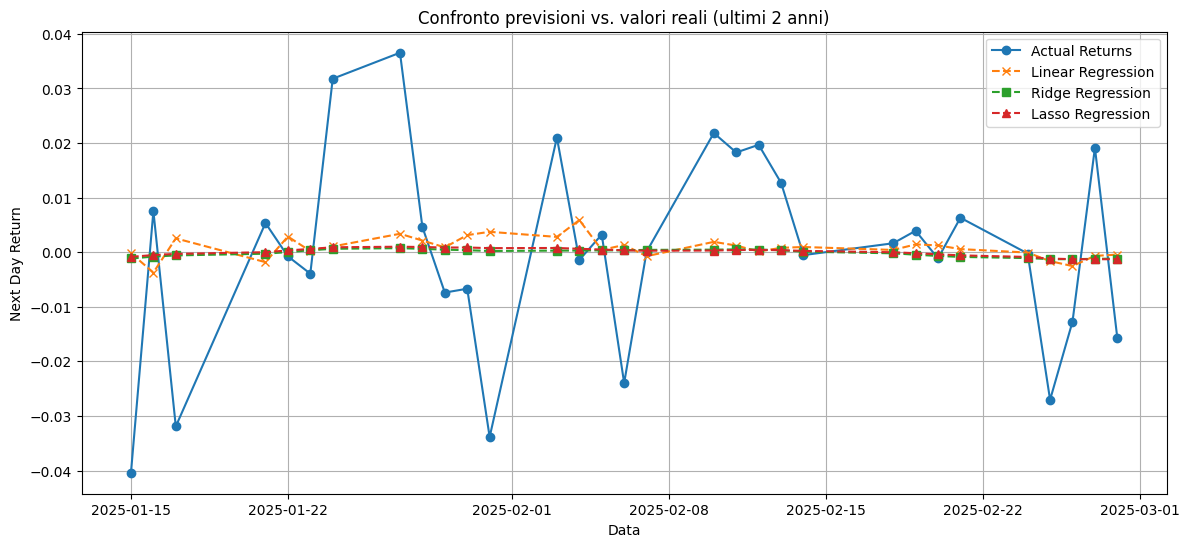


Coefficienti Linear Regression:
 Return           0.043439
MA_5             0.000273
MA_10           -0.000517
MA_20            0.000080
Volatility_10    0.112091
Lag_1_Return    -0.066172
dtype: float64

Coefficienti Ridge Regression:
 Return           1.353965e-07
MA_5            -4.795033e-05
MA_10           -6.723773e-05
MA_20           -4.875261e-05
Volatility_10    2.786294e-08
Lag_1_Return    -1.437136e-07
dtype: float64

Coefficienti Lasso Regression:
 Return           0.000000
MA_5            -0.000000
MA_10           -0.000151
MA_20           -0.000000
Volatility_10    0.000000
Lag_1_Return    -0.000000
dtype: float64

=== Riepilogo metriche ===
Linear Regression -> MSE: 0.0003326, R²: 0.0007
Ridge Regression  -> MSE: 0.0003227, R²: 0.0304
Lasso Regression  -> MSE: 0.0003240, R²: 0.0266

Analizzando solo gli ultimi 2 anni di dati, è possibile che:
- I rendimenti giornalieri siano ancora più difficili da prevedere (mercati molto volatili,
  rumore elevato, correlazioni basse 

In [ ]:

# -----------------------------
# 8. Visualizzazione
# -----------------------------
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual Returns', marker='o', linestyle='-')
plt.plot(y_test.index, lr_pred, label='Linear Regression', marker='x', linestyle='--')
plt.plot(y_test.index, ridge_pred, label='Ridge Regression', marker='s', linestyle='--')
plt.plot(y_test.index, lasso_pred, label='Lasso Regression', marker='^', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Next Day Return')
plt.title('Confronto previsioni vs. valori reali (ultimi 2 anni)')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 9. Coefficienti
# -----------------------------
lr_coefficients = pd.Series(lr_model.coef_, index=feature_cols)
ridge_coefficients = pd.Series(ridge_cv.best_estimator_.coef_, index=feature_cols)
lasso_coefficients = pd.Series(lasso_cv.best_estimator_.coef_, index=feature_cols)

print("\nCoefficienti Linear Regression:\n", lr_coefficients)
print("\nCoefficienti Ridge Regression:\n", ridge_coefficients)
print("\nCoefficienti Lasso Regression:\n", lasso_coefficients)

# -----------------------------
# 10. Conclusioni
# -----------------------------
print("\n=== Riepilogo metriche ===")
print(f"Linear Regression -> MSE: {lr_mse:.7f}, R²: {lr_r2:.4f}")
print(f"Ridge Regression  -> MSE: {ridge_mse:.7f}, R²: {ridge_r2:.4f}")
print(f"Lasso Regression  -> MSE: {lasso_mse:.7f}, R²: {lasso_r2:.4f}")

print("""
Analizzando solo gli ultimi 2 anni di dati, è possibile che:
- I rendimenti giornalieri siano ancora più difficili da prevedere (mercati molto volatili,
  rumore elevato, correlazioni basse sul breve periodo).
- La regolarizzazione (Ridge/Lasso) potrebbe non dare grandi miglioramenti se il segnale
  è debole o se le feature sono simili tra loro.
- Valori R² bassi o negativi indicano che il modello non spiega bene la varianza dei rendimenti
  di domani. È una situazione comune nei modelli lineari su orizzonti molto brevi (1 giorno).
- Potrebbe essere utile confrontare i risultati con modelli "naive" (predire la media o 0)
  o considerare orizzonti temporali più lunghi (5 o 10 giorni) o altre tipologie di feature.
""")